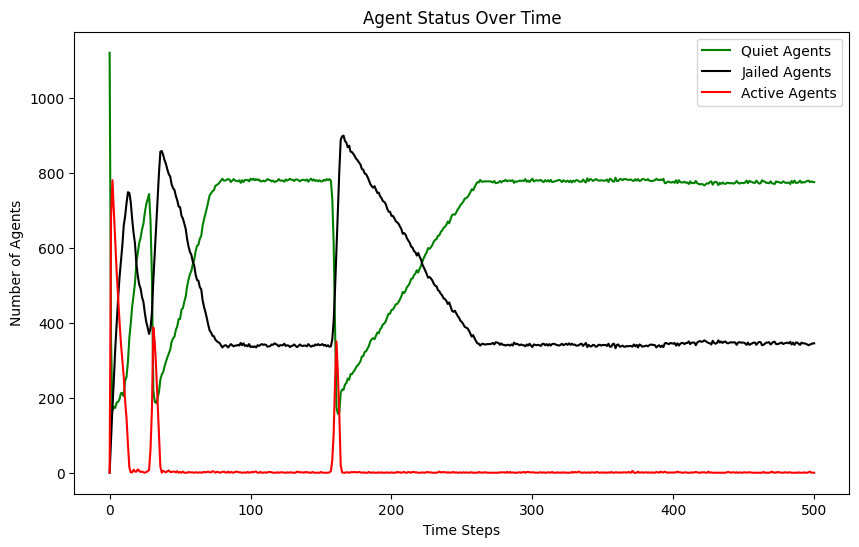

In [75]:
# origin
import random
import math
import matplotlib.pyplot as plt
from enum import Enum


class EntityType(Enum):
    AGENT = 'Agent'
    COP = 'Cop'


class Turtle:
    def __init__(self, agent_id, type, vision, risk_aversion=None, hardship=None):
        self.agent_id = agent_id
        self.type = type
        self.vision = vision
        self.risk_aversion = risk_aversion
        self.hardship = hardship
        self.active = False
        self.jail_term = 0
        self.position = (None, None)

    def __repr__(self):
        return f"{self.type}{self.agent_id}"


class Model:
    def __init__(self, agent_density, cop_density, vision, k, gov_legitimacy, max_jail_term):
        if agent_density + cop_density > 100:
            raise ValueError("The sum of agent_density and cop_density should not exceed 100%")
        self.width = 40
        self.height = 40
        self.grid = [[None for _ in range(self.height)] for _ in range(self.width)]
        self.vision = vision
        self.k = k
        self.gov_legitimacy = gov_legitimacy
        self.max_jail_term = max_jail_term
        self.entities = []  # 统一存储所有实体
        self.total_cells = self.width * self.height
        self.neighborhoods = [[[] for _ in range(self.height)] for _ in range(self.width)]
        self.compute_neighborhoods()
        self.create_entities(int((agent_density / 100) * self.total_cells), int((cop_density / 100) * self.total_cells))
        self.data = {'quiet': [int((agent_density / 100) * self.total_cells)], 'jail': [0], 'active': [0]}

    # Modification in v3:  consider the boundary condition
    def compute_neighborhoods(self):
        for x in range(self.width):
            for y in range(self.height):
                neighborhood = []
                for dx in range(-self.vision, self.vision + 1):
                    for dy in range(-self.vision, self.vision + 1):
                        # Check the distance to ensure it's within the vision radius
                        if dx ** 2 + dy ** 2 <= self.vision ** 2:
                            # Apply periodic boundary conditions
                            nx, ny = (x + dx) % self.width, (y + dy) % self.height
                            neighborhood.append((nx, ny))
                self.neighborhoods[x][y] = neighborhood

    def create_entities(self, num_agents, num_cops):
        for i in range(num_agents):
            agent = Turtle(i, EntityType.AGENT, self.vision, random.random(), random.random())
            self.place_entity_randomly(agent)
            self.entities.append(agent)
        for i in range(num_cops):
            cop = Turtle(num_agents + i, EntityType.COP, self.vision)
            self.place_entity_randomly(cop)
            self.entities.append(cop)

    def place_entity_randomly(self, entity):
        x, y = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
        while self.grid[x][y] is not None:
            x, y = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
        self.grid[x][y] = entity
        entity.position = (x, y)

    def step(self):
        # 增加了shuffle每一轮都打乱顺序
        random.shuffle(self.entities)
        quiet_count = jail_count = active_count = 0

        for entity in self.entities:
            if entity.jail_term > 0:
                entity.jail_term -= 1
                continue

            self.move_agent(entity)
            if entity.type == EntityType.AGENT:
                self.determine_behavior(entity)
            elif entity.type == EntityType.COP:
                self.enforce(entity)
        # if self.max_jail_term > 10:
            # self.max_jail_term -= 1  
        if self.max_jail_term < 100:
            self.max_jail_term += 1  

        # 每次都是前面执行结束之后才跑统计方法
        for entity in self.entities:
            if entity.jail_term > 0:
                jail_count += 1
                continue
            if entity.type == EntityType.AGENT:
                if entity.active:
                    active_count += 1
                else:
                    quiet_count += 1
        self.data['quiet'].append(quiet_count)
        self.data['jail'].append(jail_count)
        self.data['active'].append(active_count)

    def move_agent(self, agent):
        if agent.jail_term > 0:
            return  # Jailed agents do not move
        x, y = agent.position
        self.grid[x][y] = None  # Remove agent from current position
        potential_positions = []
        # Use precomputed neighborhood
        neighborhood = self.neighborhoods[x][y]
        for nx, ny in neighborhood:
            target = self.grid[nx][ny]
            if target is None:
                potential_positions.append((nx, ny))
            elif isinstance(target, Turtle) and target.jail_term > 0:
                # Include positions with only jailed agents
                potential_positions.append((nx, ny))
        if potential_positions:
            new_position = random.choice(potential_positions)
            self.grid[new_position[0]][new_position[1]] = agent
            agent.position = new_position

    def determine_behavior(self, agent):
        x, y = agent.position
        grievance = agent.hardship * (1 - self.gov_legitimacy)
        arrest_probability = self.estimate_arrest_probability((x, y))
        if grievance - (agent.risk_aversion * arrest_probability) > 0.1:
            agent.active = True
        else:
            agent.active = False

    def estimate_arrest_probability(self, position):
        x, y = position
        cops_count = 0
        active_agents_count = 0
        neighborhood = self.neighborhoods[x][y]
        for nx, ny in neighborhood:
            cell = self.grid[nx][ny]
            if isinstance(cell, Turtle):
                if cell.type == EntityType.COP:
                    cops_count += 1
                elif cell.type == EntityType.AGENT and cell.active:
                    active_agents_count += 1
        arrest_prob = 1 - math.exp(-self.k * math.floor(cops_count / (active_agents_count + 1)))
        return arrest_prob

    # Modification: collect all active agents at first and then randomly select one to jail
    def enforce(self, cop):
        x, y = cop.position
        active_agents = []
        # Collect all active agents in the neighborhood
        for nx, ny in self.neighborhoods[x][y]:
            agent = self.grid[nx][ny]
            if isinstance(agent, Turtle) and agent.active:
                active_agents.append((agent, nx, ny))
        # Randomly select one active agent to arrest
        if active_agents:
            selected_agent, nx, ny = random.choice(active_agents)
            selected_agent.active = False
            selected_agent.jail_term = random.randint(0, self.max_jail_term)
            # selected_agent.jail_term = self.max_jail_term
            # Move cop to the position of the arrested agent
            self.grid[x][y] = None  # Remove cop from current position
            self.grid[nx][ny] = cop  # Move cop to new position
            cop.position = (nx, ny)


# 实例化并运行模型
AGENT_DENSITY = 70
COP_DENSITY = 7
VISION = 7
K = 2.3
GOV_LEGITIMACY = 0.2
MAX_JAIL_TERM = 10
model = Model(AGENT_DENSITY, COP_DENSITY, VISION, K, GOV_LEGITIMACY, MAX_JAIL_TERM)
for _ in range(500):
    model.step()

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(model.data['quiet'], label='Quiet Agents', color="green")
plt.plot(model.data['jail'], label='Jailed Agents',color="black")
plt.plot(model.data['active'], label='Active Agents',color="red")
plt.xlabel('Time Steps')
plt.ylabel('Number of Agents')
plt.title('Agent Status Over Time')
plt.legend()
plt.show()

渐变
        if self.max_jail_term > 10:
            self.max_jail_term -= 1  